In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/TAN
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
# --------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

import torch.autograd
# torch.autograd.set_detect_anomaly(True)

Používané zařízení: cuda


# 4D model


In [ ]:
import torch
from math import pi
from Systems import DynamicSystem

state_dim = 6 
obs_dim = 2  
dt = 0.02      
alpha_Q = 1e-3 
alpha_P = 1e-6 

F_base = torch.tensor([[1, 0, dt, 0],
                       [0, 1, 0, dt],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]], dtype=torch.float)
B_base = torch.tensor([[0, 0],
                       [0, 0],
                       [1, 0],
                       [0, 1]], dtype=torch.float) 

F_aug = torch.zeros(6, 6, dtype=torch.float)
F_aug[0:4, 0:4] = F_base
F_aug[0:4, 4:6] = B_base
F_aug[4:6, 4:6] = torch.eye(2)


Q_base = torch.eye(4, dtype=torch.float) * 1e-6 
Q_u = torch.eye(2, dtype=torch.float) * alpha_Q
Q_aug = torch.block_diag(Q_base, Q_u)

R_val = torch.tensor([[4e-4 * (pi/180)**2, 0],  
                      [0, 1e-4]], dtype=torch.float) 

x_0_base = torch.tensor([0, 0, 0, 0], dtype=torch.float)
x_0_u = torch.zeros(2, dtype=torch.float) 
x_0_aug = torch.cat([x_0_base, x_0_u])

P_0_base = torch.eye(4, dtype=torch.float) 
P_0_u = torch.eye(2, dtype=torch.float) * alpha_P
P_0_aug = torch.block_diag(P_0_base, P_0_u)

def f_linear_augmented(x):

    return (F_aug.to(x.device) @ x.unsqueeze(-1)).squeeze(-1)

def h_polar(x):

    px = x[:, 0]
    py = x[:, 1]
    
    eps = 1e-6
    azimuth = torch.atan2(py, px+eps)
    
    range_val = torch.sqrt(px**2 + py**2)
    # Vrácení jako [B, 2]
    return torch.stack([azimuth, range_val], dim=1)

def h_linear(x):
    # x je [B, 6]
    # H matice [2, 6] = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]
    return x[:, 0:2]

obs_dim = 2

system_model = DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q_aug.float(),
    R=R_val.float(),
    Ex0=x_0_aug.float(),
    P0=P_0_aug.float(),
    f=f_linear_augmented,
    h=h_polar,
    device=device
)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
import numpy as np
import random 
from utils import trainer 
from state_NN_models import StateKalmanNet_v2 
from Systems import DynamicSystem

def generate_data(system_model, num_trajectories, seq_len, base_dist, device):
    state_dim = system_model.state_dim
    obs_dim = system_model.obs_dim
    x_data = torch.zeros(num_trajectories, seq_len, state_dim, device=device)
    y_data = torch.zeros(num_trajectories, seq_len, obs_dim, device=device)
    
    x_k = base_dist.sample((num_trajectories,))
    
    y_k = system_model.measure(x_k)
    if torch.any(torch.isnan(y_k)):
        print("VAROVÁNÍ: Detekován NaN v y_k při generování dat (krok 0)!")
        
    x_data[:, 0, :] = x_k
    y_data[:, 0, :] = y_k
    
    with torch.no_grad(): 
        for t in range(1, seq_len):
            x_k = system_model.step(x_k) 
            y_k = system_model.measure(x_k)
            
            if torch.any(torch.isnan(y_k)):
                print(f"VAROVÁNÍ: Detekován NaN v y_k při generování dat (krok {t})!")
            
            x_data[:, t, :] = x_k
            y_data[:, t, :] = y_k
            
    return x_data, y_data

TRAIN_SEQ_LEN = 100       # D (Délka segmentu pro trénink)
VALID_SEQ_LEN = 200      # D (Délka segmentu pro validaci)
NUM_TRAIN_SETS = 100    # Počet různých startovních pozic 
TRAJ_PER_SET_TRAIN = 5  # Kolik trajektorií na jednu pozici
NUM_VALID_SETS = 100
TRAJ_PER_SET_VALID = 2
BATCH_SIZE = 256        

TEST_SEQ_LEN = 800
TRAJ_PER_SET_TEST = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

original_system_model = system_model 
default_P0 = original_system_model.P0.clone()
default_Ex0 = original_system_model.Ex0.clone()
state_dim = original_system_model.state_dim
obs_dim = original_system_model.obs_dim
print(f"Benchmark model načten: State Dim={state_dim}, Obs Dim={obs_dim}")

POS_MEAN_RANGE_X_MIN = 500.0  # Minimální startovní pozice X
POS_MEAN_RANGE_X_MAX = 5000.0 # Maximální startovní pozice X
POS_MEAN_RANGE_Y = 5000.0     # Rozsah Y +/-
VEL_MEAN_RANGE = 20.0         # Rozsah rychlosti +/-

print(f"Generuji trajektorie v 'bezpečné zóně': x > {POS_MEAN_RANGE_X_MIN}")

# --- Generování trénovacích dat ---
print("Generuji trénovací data...")
all_x_train = []
all_y_train = []

for i in range(NUM_TRAIN_SETS):
    # Vytvoříme náhodný posun POUZE v bezpečné zóně
    random_pos_offset_x = (torch.rand((), device=device) * (POS_MEAN_RANGE_X_MAX - POS_MEAN_RANGE_X_MIN)) + POS_MEAN_RANGE_X_MIN
    random_pos_offset_y = (torch.rand((), device=device) * 2 - 1) * POS_MEAN_RANGE_Y
    random_vel_offset = (torch.rand(2, device=device) * 2 - 1) * VEL_MEAN_RANGE
    
    current_Ex0 = default_Ex0.clone()
    current_Ex0[0] += random_pos_offset_x
    current_Ex0[1] += random_pos_offset_y
    current_Ex0[2:4] += random_vel_offset
    
    current_base_dist = torch.distributions.MultivariateNormal(current_Ex0, default_P0)

    x_batch, y_batch = generate_data(
        original_system_model,
        num_trajectories=TRAJ_PER_SET_TRAIN,
        seq_len=TRAIN_SEQ_LEN,
        base_dist=current_base_dist,
        device=device
    )
    all_x_train.append(x_batch)
    all_y_train.append(y_batch)

x_train = torch.cat(all_x_train, dim=0)
y_train = torch.cat(all_y_train, dim=0)
print(f"Finální trénovací data: x={x_train.shape}, y={y_train.shape}")

# --- Generování validačních dat ---
print("Generuji validační data...")
all_x_val = []
all_y_val = []
for i in range(NUM_VALID_SETS):
    # Opět v bezpečné zóně
    random_pos_offset_x = (torch.rand((), device=device) * (POS_MEAN_RANGE_X_MAX - POS_MEAN_RANGE_X_MIN)) + POS_MEAN_RANGE_X_MIN
    random_pos_offset_y = (torch.rand((), device=device) * 2 - 1) * POS_MEAN_RANGE_Y
    random_vel_offset = (torch.rand(2, device=device) * 2 - 1) * VEL_MEAN_RANGE
    
    current_Ex0 = default_Ex0.clone()
    current_Ex0[0] += random_pos_offset_x
    current_Ex0[1] += random_pos_offset_y
    current_Ex0[2:4] += random_vel_offset
    
    current_base_dist = torch.distributions.MultivariateNormal(current_Ex0, default_P0)

    x_batch, y_batch = generate_data(
        original_system_model,
        num_trajectories=TRAJ_PER_SET_VALID,
        seq_len=VALID_SEQ_LEN,
        base_dist=current_base_dist,
        device=device
    )
    all_x_val.append(x_batch)
    all_y_val.append(y_batch)

x_val = torch.cat(all_x_val, dim=0)
y_val = torch.cat(all_y_val, dim=0)
print(f"Finální validační data: x={x_val.shape}, y={y_val.shape}")


x_train_flat = x_train.view(-1, state_dim)
x_mean = x_train_flat.mean(dim=0).to(device)
x_std = x_train_flat.std(dim=0).to(device)
x_std[x_std == 0] = 1.0 
print(f"  Vypočtený průměr stavů (x_mean): {x_mean.cpu().numpy()}")
print(f"  Vypočtená odchylka stavů (x_std): {x_std.cpu().numpy()}")

y_train_flat = y_train.view(-1, obs_dim)
y_mean = y_train_flat.mean(dim=0).to(device)
y_std = y_train_flat.std(dim=0).to(device)
y_std[y_std == 0] = 1.0 
print(f"  Vypočtený průměr měření (y_mean): {y_mean.cpu().numpy()}")
print(f"  Vypočtená odchylka měření (y_std): {y_std.cpu().numpy()}")



print("Generuji testovací data...")
all_x_test = []
all_y_test = []
for i in range(1):
    random_pos_offset_x = (torch.rand((), device=device) * (POS_MEAN_RANGE_X_MAX - POS_MEAN_RANGE_X_MIN)) + POS_MEAN_RANGE_X_MIN
    random_pos_offset_y = (torch.rand((), device=device) * 2 - 1) * POS_MEAN_RANGE_Y
    random_vel_offset = (torch.rand(2, device=device) * 2 - 1) * VEL_MEAN_RANGE
    
    current_Ex0 = default_Ex0.clone()
    current_Ex0[0] += random_pos_offset_x
    current_Ex0[1] += random_pos_offset_y
    current_Ex0[2:4] += random_vel_offset
    
    current_base_dist = torch.distributions.MultivariateNormal(current_Ex0, default_P0)

    x_batch, y_batch = generate_data(
        original_system_model,
        num_trajectories=TRAJ_PER_SET_TEST,
        seq_len=TEST_SEQ_LEN,
        base_dist=current_base_dist,
        device=device
    )
    all_x_test.append(x_batch)
    all_y_test.append(y_batch)

x_test = torch.cat(all_x_test, dim=0)
y_test = torch.cat(all_y_test, dim=0)
print(f"Finální testovací data: x={x_test.shape}, y={y_test.shape}")

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("\nDataLoadery jsou připraveny pro trénink.")

Používané zařízení: cuda
Benchmark model načten: State Dim=6, Obs Dim=2
Generuji trajektorie v 'bezpečné zóně': x > 500.0
Generuji trénovací data...
Finální trénovací data: x=torch.Size([1000, 50, 6]), y=torch.Size([1000, 50, 2])
Generuji validační data...
Finální validační data: x=torch.Size([500, 200, 6]), y=torch.Size([500, 200, 2])
  Vypočtený průměr stavů (x_mean): [ 2.5563652e+03 -1.2255810e+02 -1.3135456e+00 -8.7917584e-01
 -1.9518060e-03 -5.7329559e-03]
  Vypočtená odchylka stavů (x_std): [1.2715370e+03 3.1851577e+03 1.1430746e+01 1.1619803e+01 1.5562688e-01
 1.5455738e-01]
  Vypočtený průměr měření (y_mean): [1.6031135e+00 4.0525823e+03]
  Vypočtená odchylka měření (y_std): [   1.6197791 1374.2039   ]
Generuji testovací data...
Finální testovací data: x=torch.Size([1, 800, 6]), y=torch.Size([1, 800, 2])

DataLoadery jsou připraveny pro trénink.


In [ ]:

state_knet2 = StateKalmanNet_v2(
    system_model=original_system_model, 
    device=device,
    hidden_size_multiplier=6,
    output_layer_multiplier=4,
    num_gru_layers=2,
    gru_hidden_dim_multiplier=6
)

trained_model = trainer.train_state_KalmanNet_sliding_window(
    model=state_knet2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=200,
    lr=1e-4,
    clip_grad=1.0,
    early_stopping_patience=20,
    tbptt_k=2,
    tbptt_w=6,
    optimizer_=torch.optim.AdamW,
    weight_decay_=1e-4,

)

INFO: Detekováno z atributu modelu, že vrací kovarianci: False
INFO: Spouštím trénink s TBPTT(k=2, w=6)
Nové nejlepší model uloženo! Epoch [2/200], Train Loss: 2325242.571175, Val Loss: 15037191931341805296914792448.000000
Nové nejlepší model uloženo! Epoch [3/200], Train Loss: 8.890343, Val Loss: 231231905890207413567488.000000
Nové nejlepší model uloženo! Epoch [4/200], Train Loss: 10.759413, Val Loss: 99778.690430
Epoch [5/200], Train Loss: 5.169660, Val Loss: 446955.304688
Nové nejlepší model uloženo! Epoch [6/200], Train Loss: 3.852138, Val Loss: 16031.170410
Nové nejlepší model uloženo! Epoch [9/200], Train Loss: 6.037528, Val Loss: 1402.293243
Epoch [10/200], Train Loss: 3.648193, Val Loss: 94633617527931424.000000
Nové nejlepší model uloženo! Epoch [12/200], Train Loss: 3.468312, Val Loss: 1355.626648
Epoch [15/200], Train Loss: 3.328302, Val Loss: 959.912598
Nové nejlepší model uloženo! Epoch [15/200], Train Loss: 3.328302, Val Loss: 959.912598
Epoch [20/200], Train Loss: 3.13

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=10000)

all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knet_F3_cpu = []
all_x_hat_classic_knet2_cpu = []
# all_x_hat_classic_knet3_cpu = []
NUM_TEST_TRAJ = 1
all_knet2_diagnostics_cpu = []
# all_knet3_diagnostics_cpu = []
print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

# state_knet.eval()
state_knet2.eval()
# state_knet3.eval()
# state_knet_F3.eval()


with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        initial_state_cpu = initial_state.squeeze(0).cpu()

        # # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        # ensemble_trajectories = []
        # for j in range(J_SAMPLES_TEST):
        #     state_bkn_knet.reset(batch_size=1, initial_state=initial_state)
        #     current_x_hats = []
        #     for t in range(1, TEST_SEQ_LEN):
        #         x_filtered_t, _ = state_bkn_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #         current_x_hats.append(x_filtered_t)
        #     ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        # ensemble = torch.stack(ensemble_trajectories, dim=0)
        # predictions_bkn = ensemble.mean(dim=0)
        # diff = ensemble - predictions_bkn.unsqueeze(0)
        # covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        # full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        # full_P_hat_bkn = torch.cat([system_model.P0.unsqueeze(0), covariances_bkn], dim=0)


        # --- B. Klasický StateKalmanNet (pouze MSE) ---
        # state_knet.reset(batch_size=1, initial_state=initial_state)
        # classic_knet_preds = []
        # for t in range(1, TEST_SEQ_LEN):
        #     x_filtered_t = state_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #     classic_knet_preds.append(x_filtered_t)
        # full_x_hat_classic_knet = torch.cat([initial_state, torch.cat(classic_knet_preds, dim=0)], dim=0)
        # diagnostics = state_knet.get_diagnostics()
        # all_knet_diagnostics_cpu.append(diagnostics)

        state_knet2.reset(batch_size=1, initial_state=initial_state)
        classic_knet2_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet2.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet2_preds.append(x_filtered_t)
        full_x_hat_classic_knet2 = torch.cat([initial_state, torch.cat(classic_knet2_preds, dim=0)], dim=0)
        # diagnostics_knet2 = state_knet2.get_diagnostics()

        # state_knet3.reset(batch_size=1, initial_state=initial_state)
        # classic_knet3_preds = []
        # for t in range(1, TEST_SEQ_LEN):
        #     x_filtered_t = state_knet3.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #     classic_knet3_preds.append(x_filtered_t)
        # full_x_hat_classic_knet3 = torch.cat([initial_state, torch.cat(classic_knet3_preds, dim=0)], dim=0)
        # diagnostics_knet3 = state_knet3.get_diagnostics()

        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
             Ex0=initial_state, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=initial_state,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        # all_x_hat_knet_F3_cpu.append(full_x_hat_classic_knet_F3.cpu())
        # all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_classic_knet2_cpu.append(full_x_hat_classic_knet2.cpu())
        # all_x_hat_classic_knet3_cpu.append(full_x_hat_classic_knet3.cpu())
        # all_x_hat_classic_knet_cpu.append(full_x_hat_classic_knet.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())

        # all_knet2_diagnostics_cpu.append(diagnostics_knet2)
        # all_knet3_diagnostics_cpu.append(diagnostics_knet3)
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []
# mse_classic_knet = []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []
mse_classic_knet3 = []
mse_classic_knet2 = []
# mse_knet_F3 = []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(1):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat_full, P_hat_full):
            if x_hat_full.shape[0] != x_true.shape[0] or P_hat_full.shape[0] != x_true.shape[0]:
                 raise ValueError(f"Nesoulad délek! x_true: {x_true.shape[0]}, x_hat: {x_hat_full.shape[0]}, P_hat: {P_hat_full.shape[0]}")

            # Porovnáváme od kroku t=1
            mse = F.mse_loss(x_hat_full[1:], x_true[1:]).item()
            # ANEES se také typicky počítá od t=1 (ignoruje počáteční nejistotu P0)
            anees = utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0),
                x_hat_full[1:].unsqueeze(0),
                P_hat_full[1:].unsqueeze(0)
            )
            return mse, anees

        # Výpočty pro všechny modely
        # mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        # mse = F.mse_loss(all_x_hat_knet_F3_cpu[i][1:], x_true[1:]).item(); mse_knet_F3.append(mse)
        mse = F.mse_loss(all_x_hat_classic_knet2_cpu[i][1:], x_true[1:]).item(); mse_classic_knet2.append(mse)
        # mse = F.mse_loss(all_x_hat_classic_knet3_cpu[i][1:], x_true[1:]).item(); mse_classic_knet3.append(mse)
        # mse = F.mse_loss(all_x_hat_classic_knet_cpu[i][1:], x_true[1:]).item(); mse_classic_knet.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
        print("\n" + "="*80)
        print(f"trajektorie: {i + 1}/{NUM_TEST_TRAJ}")
        print("="*80)
        print("-" * 80)
        # print(f"{'Bayesian KNet (BKN)':<35} | {(mse_bkn[i]):<20.4f} | {(anees_bkn[i]):<20.4f}")
        # print(f"{'KNet F3 (pouze MSE)':<35} | {(mse_knet_F3[i]):<20.4f} | {'N/A':<20}")
        print(f"{'KNet2 (pouze MSE)':<35} | {(mse_classic_knet2[i]):<20.4f} | {'N/A':<20}")
        # print(f"{'KNet3 (pouze MSE)':<35} | {(mse_classic_knet3[i]):<20.4f} | {'N/A':<20}")
        # print(f"{'KNet (pouze MSE)':<35} | {(mse_classic_knet[i]):<20.4f} | {'N/A':<20}")
        print(f"{'UKF (Ideální model)':<35} | {(mse_ukf_ideal[i]):<20.4f} | {(anees_ukf_ideal[i]):<20.4f}")
        print(f"{'PF-SIR (Ideální model)':<35} | {(mse_pf_sir_ideal[i]):<20.4f} | {(anees_pf_sir_ideal[i]):<20.4f}")
        print("="*80)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
# print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
# print(f"{'KNet (pouze MSE)':<35} | {avg(mse_classic_knet):<20.4f} | {'N/A':<20}")
print(f"{'KNet2 (pouze MSE)':<35} | {avg(mse_classic_knet2):<20.4f} | {'N/A':<20}")
# print(f"{'KNet3 (pouze MSE)':<35} | {avg(mse_classic_knet3):<20.4f} | {'N/A':<20}")
# print(f"{'KNet F3 (pouze MSE)':<35} | {avg(mse_knet_F3):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)


Vyhodnocuji modely na 1 testovacích trajektoriích...
PF-SIR (ideální model) dokončen pro trajektorii 1/1.
Dokončena trajektorie 1/1...

Počítám finální metriky pro jednotlivé trajektorie...

trajektorie: 1/1
--------------------------------------------------------------------------------
KNet2 (pouze MSE)                   | 12558.8682           | N/A                 
UKF (Ideální model)                 | 1.1897               | 5.5023              
PF-SIR (Ideální model)              | 1.3537               | 9.0609              

FINÁLNÍ VÝSLEDKY (průměr přes 1 běhů)
Model                               | Průměrné MSE         | Průměrný ANEES      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--- Model-Based Filters ---         |                      |                     
KNet2 (pouze MSE)                   | 12558.8682           | N/A                 
-----------------

Varování: Diagnostika pro 'KNet2' nenalezena. Grafy nebudou vykresleny.


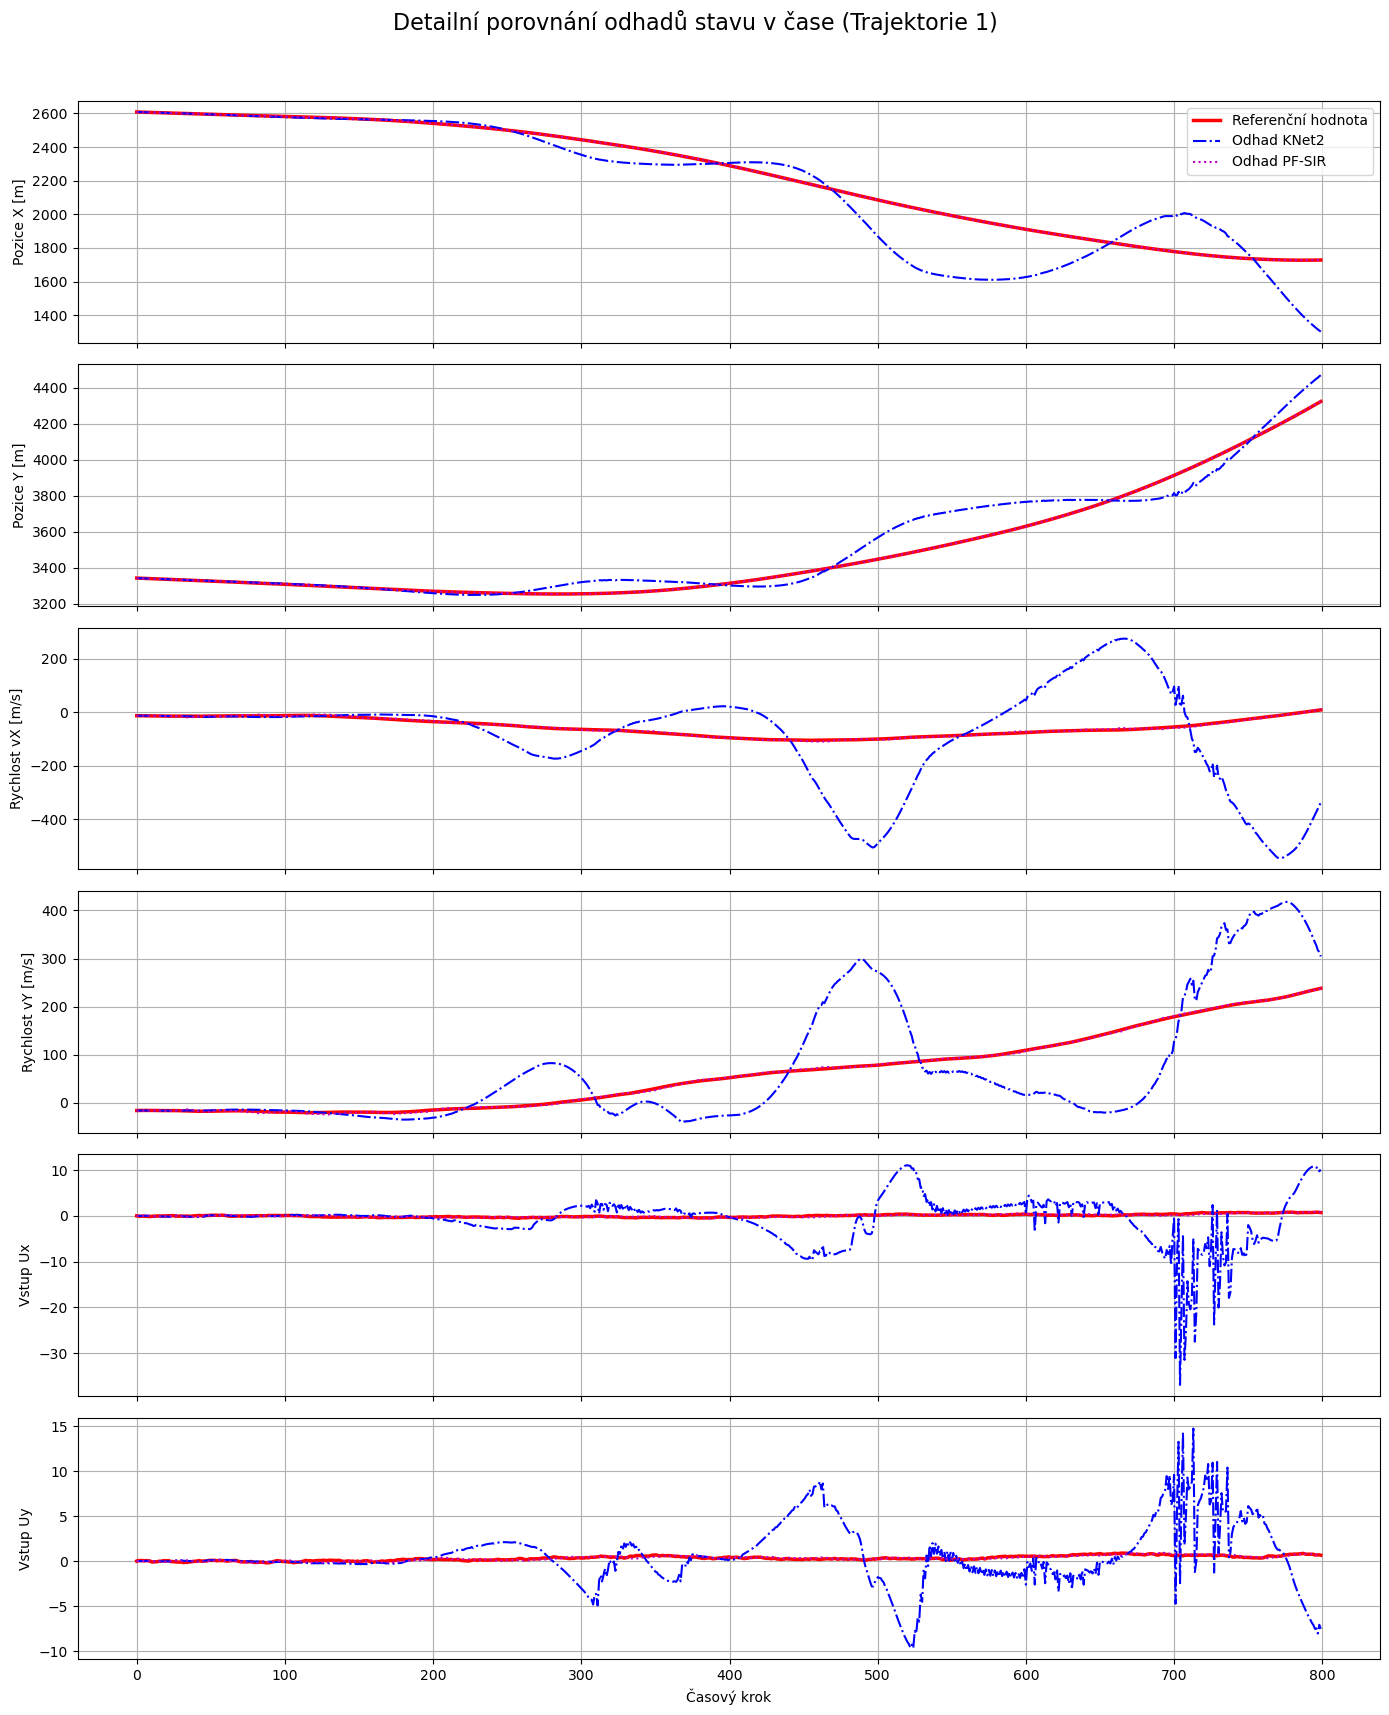

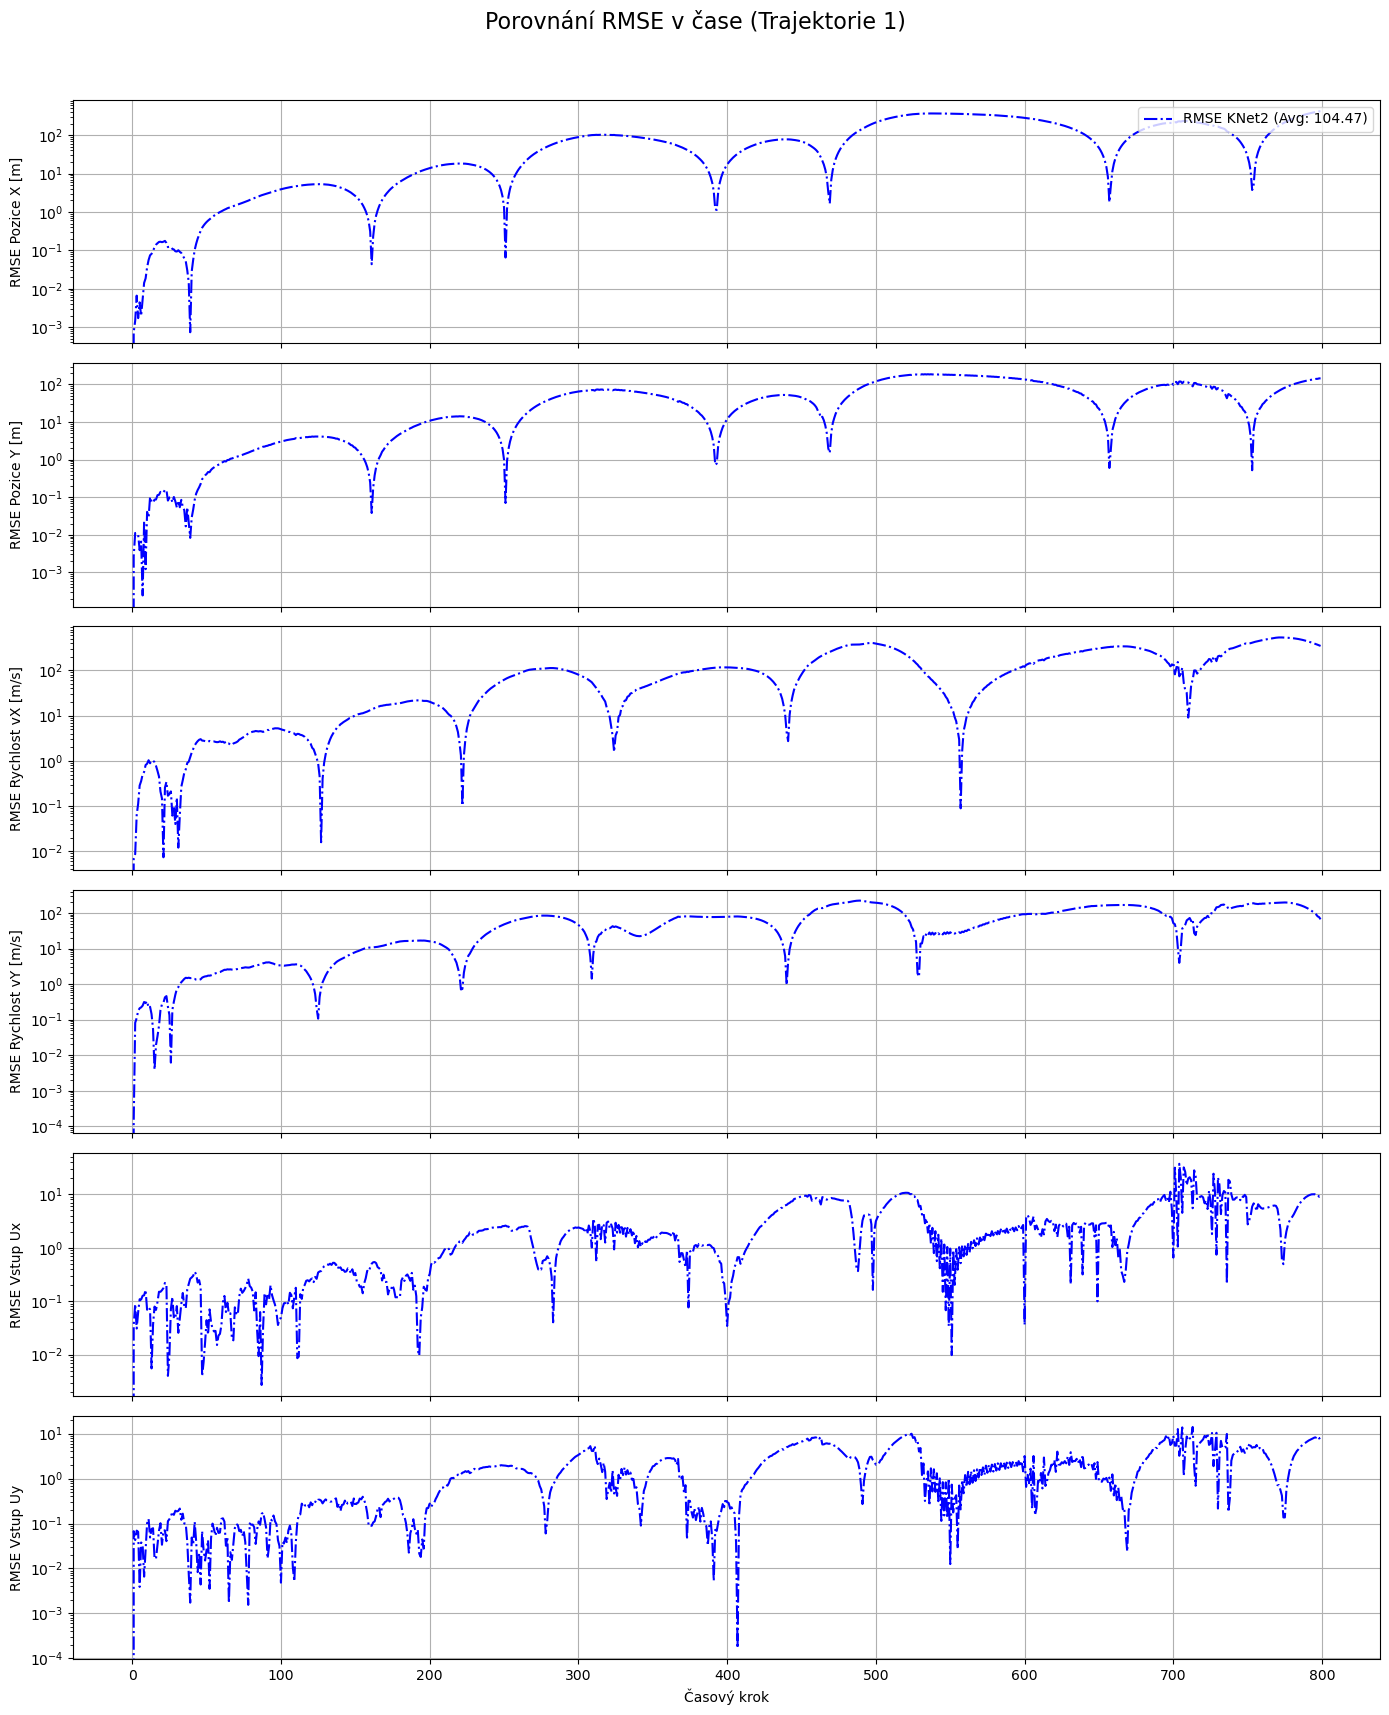

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

index = 0
if index < 0: index = 0

x_true_tensor = all_x_true_cpu[index]
x_pf_tensor = all_x_hat_pf_sir_ideal_cpu[index]
x_knet2_tensor = all_x_hat_classic_knet2_cpu[index]


x_true_plot = x_true_tensor.numpy()
num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps)
gain_time_axis = np.arange(1, num_steps)


rmse_knet2_per_step = torch.sqrt((x_knet2_tensor - x_true_tensor)**2).numpy()

def extract_diagnostics(diagnostics_dict, time_axis, gain_time_axis):
    diag_data = {}
    plot_flags = {'gains': False, 'h_norm': False, 'innov_norm': False, 'inputs_norm': False}
    
    try:
        kalman_gains_history = diagnostics_dict['K_history']
        
        gains_col0_cpu = [K[0, :, 0].cpu().numpy() for K in kalman_gains_history]
        diag_data['gains_col0_np'] = np.array(gains_col0_cpu) # [T-1, 6]
        
        gains_col1_cpu = [K[0, :, 1].cpu().numpy() for K in kalman_gains_history]
        diag_data['gains_col1_np'] = np.array(gains_col1_cpu) # [T-1, 6]

        if diag_data['gains_col0_np'].shape[0] == len(gain_time_axis):
            plot_flags['gains'] = True
        else:
            print(f"Varování: Délka historie zisku K ({diag_data['gains_col0_np'].shape[0]}) neodpovídá časové ose ({len(gain_time_axis)}).")

        h_history = diagnostics_dict['h_history']

        h_norms = [
            (torch.norm(h['h_Q'].squeeze(1)) + 
             torch.norm(h['h_Sigma'].squeeze(1)) + 
             torch.norm(h['h_S'].squeeze(1))).item()
            for h in h_history
        ]
        diag_data['h_norms_np'] = np.array(h_norms) # [T]
        
        if len(diag_data['h_norms_np']) == len(time_axis):
            plot_flags['h_norm'] = True
        else:
            print(f"Varování: Délka historie stavu h ({len(diag_data['h_norms_np'])}) neodpovídá časové ose ({len(time_axis)}).")

        innovation_history = diagnostics_dict['innovation_history']
        innov_norms = [torch.norm(innov.squeeze(0)).item() for innov in innovation_history]
        diag_data['innov_norms_np'] = np.array(innov_norms) # [T-1]
        
        if len(diag_data['innov_norms_np']) == len(gain_time_axis):
            plot_flags['innov_norm'] = True
        else:
            print(f"Varování: Délka historie inovace ({len(diag_data['innov_norms_np'])}) neodpovídá časové ose ({len(gain_time_axis)}).")

        inputs_history = diagnostics_dict['inputs_history']
        inputs_norms = [torch.norm(inp.squeeze(0)).item() for inp in inputs_history]
        diag_data['inputs_norms_np'] = np.array(inputs_norms) # [T-1]

        if len(diag_data['inputs_norms_np']) == len(gain_time_axis):
            plot_flags['inputs_norm'] = True
        else:
            print(f"Varování: Délka historie vstupů ({len(diag_data['inputs_norms_np'])}) neodpovídá časové ose ({len(gain_time_axis)}).")

    except Exception as e:
        print(f"Nastala chyba při extrakci diagnostiky: {e}")
        
    return diag_data, plot_flags

try:
    knet2_diag_data, knet2_plot_flags = extract_diagnostics(all_knet2_diagnostics_cpu[index], time_axis, gain_time_axis)
    plot_diag_knet2 = True
except (NameError, IndexError):
    print("Varování: Diagnostika pro 'KNet2' nenalezena. Grafy nebudou vykresleny.")
    plot_diag_knet2 = False

state_dim = x_true_plot.shape[1]
obs_dim = all_x_hat_pf_sir_ideal_cpu[index].shape[1] if len(all_x_hat_pf_sir_ideal_cpu) > 0 else 2 # Placeholder

state_labels = [
    'Pozice X [m]',
    'Pozice Y [m]',
    'Rychlost vX [m/s]',
    'Rychlost vY [m/s]',
    'Vstup Ux',
    'Vstup Uy'
]
error_labels = [f'RMSE {label}' for label in state_labels]

gain_labels_col0 = [f'K[{i},0] (Azimut -> {state_labels[i].split(" ")[0]})' for i in range(state_dim)]
gain_labels_col1 = [f'K[{i},1] (Vzdál. -> {state_labels[i].split(" ")[0]})' for i in range(state_dim)]

diagnostic_labels = {
    'h_norm': 'L2 Norma skrytých stavů $h_t$ (Q+Sigma+S)',
    'innov_norm': 'L2 Norma inovace $\Delta y_t$',
    'inputs_norm': 'L2 Norma vstupních rysů $F_{1..4}$'
}

fig1, axes1 = plt.subplots(state_dim, 1, figsize=(14, 18), sharex=True)
fig1.suptitle(f'Detailní porovnání odhadů stavu v čase (Trajektorie {index+1})', fontsize=16)

fig2, axes2 = plt.subplots(state_dim, 1, figsize=(14, 18), sharex=True)
fig2.suptitle(f'Porovnání RMSE v čase (Trajektorie {index+1})', fontsize=16)

for i in range(state_dim):
    ax1 = axes1[i]
    ax1.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.5, label='Referenční hodnota')
    ax1.plot(time_axis, x_knet2_tensor[:, i].numpy(), 'b-.', linewidth=1.5, label='Odhad KNet2')

    if x_pf_tensor.shape[1] == state_dim:
         ax1.plot(time_axis, x_pf_tensor[:, i].numpy(), 'm:', linewidth=1.5, label='Odhad PF-SIR')
            
    ax1.set_ylabel(state_labels[i])
    ax1.grid(True)
    

    ax2 = axes2[i]
    ax2.plot(time_axis, rmse_knet2_per_step[:, i], 'b-.', linewidth=1.5, label=f'RMSE KNet2 (Avg: {np.mean(rmse_knet2_per_step[1:, i]):.2f})')

    ax2.set_ylabel(error_labels[i])
    ax2.grid(True)
    ax2.set_yscale('log')
    
axes1[0].legend(loc='upper right')
axes1[-1].set_xlabel('Časový krok')
axes2[0].legend(loc='upper right')
axes2[-1].set_xlabel('Časový krok')

fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
fig2.tight_layout(rect=[0, 0.03, 1, 0.96])


def plot_full_diagnostics(model_name, diag_data, plot_flags, time_axis, gain_time_axis):
    if not any(plot_flags.values()):
        print(f"Nebylo co vykreslit pro {model_name}.")
        return

    fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
    fig.suptitle(f'Hloubková diagnostika modelu: {model_name} (Trajektorie {index+1})', fontsize=16)
    
    (ax_gain0, ax_gain1, ax_h, ax_innov) = axes

    if plot_flags['gains']:
        gains_to_plot = diag_data['gains_col0_np']
        for i in range(state_dim):
            ax_gain0.plot(gain_time_axis, gains_to_plot[:, i], linewidth=1.5, label=f'{gain_labels_col0[i]} (Avg: {np.mean(gains_to_plot[:, i]):.4f})')
        ax_gain0.set_ylabel('Kalmanův zisk K[:, 0] (z Azimutu)')
        ax_gain0.grid(True)
        ax_gain0.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if plot_flags['gains']:
        gains_to_plot = diag_data['gains_col1_np']
        for i in range(state_dim):
            ax_gain1.plot(gain_time_axis, gains_to_plot[:, i], linewidth=1.5, label=f'{gain_labels_col1[i]} (Avg: {np.mean(gains_to_plot[:, i]):.4f})')
        ax_gain1.set_ylabel('Kalmanův zisk K[:, 1] (ze Vzdálenosti)')
        ax_gain1.grid(True)
        ax_gain1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if plot_flags['h_norm']:
        ax_h.plot(time_axis, diag_data['h_norms_np'], 'darkorange', linewidth=1.5, label=f'Norma $h_t$')
        ax_h.set_ylabel(diagnostic_labels['h_norm'])
        ax_h.grid(True)
        ax_h.legend(loc='upper right')
        ax_h.set_yscale('log')
        

    if plot_flags['innov_norm']:
        ax_innov.plot(gain_time_axis, diag_data['innov_norms_np'], 'purple', linewidth=2.0, label=f'Norma Inovace (Avg: {np.mean(diag_data["innov_norms_np"]):.2f})')
        ax_innov.set_ylabel(diagnostic_labels['innov_norm'], color='purple')
        ax_innov.tick_params(axis='y', labelcolor='purple')
        ax_innov.grid(True)
        ax_innov.set_yscale('log')
        ax_innov.legend(loc='upper left')

    if plot_flags['inputs_norm']:
        ax_inputs = ax_innov.twinx()
        ax_inputs.plot(gain_time_axis, diag_data['inputs_norms_np'], 'teal', linestyle=':', linewidth=2.0, label=f'Norma Vstupních Rysů (Avg: {np.mean(diag_data["inputs_norms_np"]):.2f})')
        ax_inputs.set_ylabel(diagnostic_labels['inputs_norm'], color='teal')
        ax_inputs.tick_params(axis='y', labelcolor='teal')
        ax_inputs.set_yscale('log')
        ax_inputs.legend(loc='upper right')

    ax_innov.set_xlabel('Časový krok')
    fig.tight_layout(rect=[0, 0.03, 0.85, 0.96]) 

if plot_diag_knet2:
    plot_full_diagnostics("KNet2", knet2_diag_data, knet2_plot_flags, time_axis, gain_time_axis)

plt.show()